## Text segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import fastai
# fastai.torch_core.defaults.device = 'cpu'

In [3]:
data = Path('../../data/')
codes = np.loadtxt(data/"codes.txt", dtype=str); codes
label = data/"mask_images"
image = data/"train_images"
get_y = lambda x: label/f"{x.stem}.jpg"

## Data

In [4]:
fnames = get_image_files(image)
fnames[:3]

[PosixPath('../../data/train_images/gt_2631.jpg'),
 PosixPath('../../data/train_images/gt_2184.jpg'),
 PosixPath('../../data/train_images/gt_2670.jpg')]

In [5]:
lbl_names = get_image_files(label)
lbl_names[:3]

[PosixPath('../../data/mask_images/gt_835.jpg'),
 PosixPath('../../data/mask_images/gt_4916.jpg'),
 PosixPath('../../data/mask_images/gt_1587.jpg')]

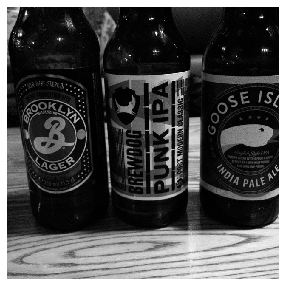

In [6]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: label/f'{x.stem}.jpg'

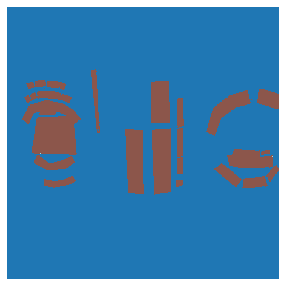

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([640, 640]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
codes = np.loadtxt(data/'codes.txt', dtype=str); codes

array(['text', 'background'], dtype='<U10')

## Datasets

In [11]:
size = src_size//2
print(size)
bs=4
free = gpu_mem_get_free_no_cache()
print(free)
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

[320 320]
432


In [12]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(image)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes) )

In [13]:
data = (src.transform(get_transforms(), size=size, tfm_y=True )
        .databunch(bs=bs)
        .normalize(imagenet_stats))

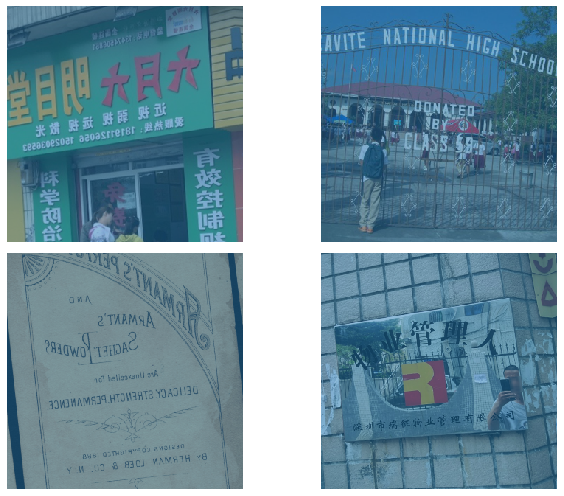

In [14]:
data.show_batch(5, figsize=(10,7))

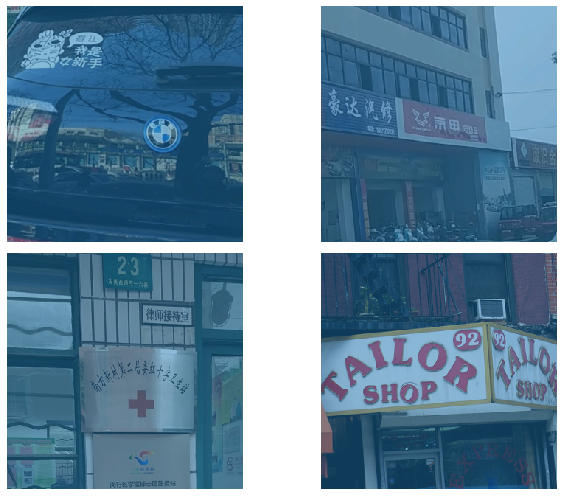

In [15]:
data.show_batch(5, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
# void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
#     mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

{'text': 0, 'background': 1}


In [17]:
metrics=acc_camvid
# metrics=accuracy

In [18]:
wd=1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [20]:
data.classes

array(['text', 'background'], dtype='<U10')

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


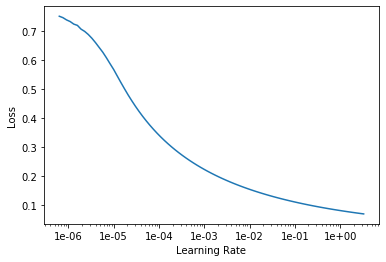

In [21]:
lr_find(learn)
learn.recorder.plot()

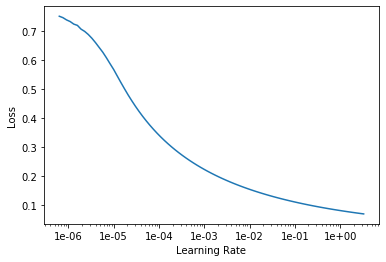

In [22]:
learn.recorder.plot()

In [23]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 160, 160]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 160, 160]       128        True      
______________________________________________________________________
ReLU                 [64, 160, 160]       0          False     
______________________________________________________________________
MaxPool2d            [64, 80, 80]         0          False     
______________________________________________________________________
Conv2d               [64, 80, 80]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 80, 80]         128        True      
______________________________________________________________________
ReLU                 [64, 80, 80]         0          False     
__________________________________________________

In [25]:
lr=1e-5

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.008058,0.005654,0.999021,06:09
1,0.000132,0.000087,1.000000,06:07
2,0.000003,0.000002,1.000000,06:08
3,0.000000,0.000000,1.000000,06:08
4,0.000000,0.000000,1.000000,06:07
5,0.000000,0.000000,1.000000,06:07
6,0.000000,0.000000,1.000000,06:07
7,0.000000,0.000000,1.000000,06:07
8,0.000000,0.000000,1.000000,06:08
9,0.000000,0.000000,1.000000,06:07


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

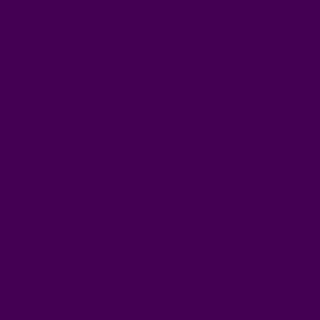

In [30]:
img = open_image('../../data/gt_1405.jpg')

prediction = learn.predict(img)[0]

prediction